# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [ ]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
%pip install umap
%pip install umap-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

import optuna
from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history
import pickle

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/datasets/'
dataset='competencia_01_fe.csv'

base_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [540079, 250829, 314299, 302111, 801007]

def ganancia_prob(y_hat, y, prop=1, class_index=1, threshold=0.025):
  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == 1 else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop


In [3]:
data = pd.read_csv(dataset_path + dataset)

In [4]:
df_train=data.copy()
df_train.shape

(981946, 312)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [5]:
# Filtro 3 meses de entrenamiento, ya que hice lag2
mes_train = [202102,202103,202104]
df_train = df_train[df_train['foto_mes'].isin(mes_train)]


# df_train = df_train[df_train['foto_mes']==202104] 
# df_train.shape



In [6]:
## elimino columnas duplicadas que se me crear al hacer merge de las distintas tablas en sql.. solucionar a futuro
df_clean = df_train.drop(columns=['foto_mes_1', 'foto_mes_2','foto_mes_3', 'foto_mes_4','foto_mes_5', 'numero_de_cliente_1','numero_de_cliente_2','numero_de_cliente_3','numero_de_cliente_4','numero_de_cliente_5'])

# Preparo la data para entrenar cada modelo

### funciones generales

In [7]:
def prepare_data(df):
    y = df["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
    X = df.drop("clase_ternaria", axis=1)
    return X, y

def sample_data(X, y, sample_size=5000,seed=semillas[0]):

    np.random.seed(seed)
    continua_sample = y[y == 0].sample(sample_size).index  # Muestra aleatoria de clase 0
    bajas_1_2 = y[y == 1].index  # Índices de clase 1
    rf_index = continua_sample.union(bajas_1_2)  # Unión de índices

    X_sample = X.loc[rf_index]  # Filtra X usando los índices seleccionados
    y_sample = y.loc[rf_index]  # Filtra y usando los índices seleccionados

    return X_sample, y_sample

def train_random_forest(X, y, n_estimators=100, max_depth=10, min_samples_leaf=40, strategy='median', random_state=semillas[0]):
 
    # Imputar valores faltantes
    imp_mean = SimpleImputer(missing_values=np.nan, strategy=strategy)
    X_imputed = imp_mean.fit_transform(X)

    # Entrenar RandomForestClassifier
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    
    model.fit(X_imputed, y)

    return model, X_imputed

Empiezo con el df con todas las variables, para poder seleccionar algunas

In [14]:
Xtrain, ytrain = prepare_data(df_clean)

In [15]:
ytrain.value_counts()

clase_ternaria
0    484447
1      5974
Name: count, dtype: int64

In [10]:
Xtrain_rf, ytrain_rf = sample_data(Xtrain, ytrain)

In [19]:
ytrain_rf.value_counts()

clase_ternaria
1    5974
0    5000
Name: count, dtype: int64

In [20]:
len(ytrain_rf)

10974

In [21]:
model_rf, Xtrain_rf_imp = train_random_forest(Xtrain_rf, ytrain_rf)

Miro la importancia de cada df y anoto las que mejor dan. 

In [22]:
def get_feature_importance(model, X, top_n=50):
    importances = model.feature_importances_  # Obtiene la importancia de las características
    features = X.columns  # Nombres de las características
    feat_importances = pd.DataFrame({'feature': features, 'importance': importances})  # Crea un DataFrame
    feat_importances = feat_importances.sort_values('importance', ascending=False)  # Ordena por importancia

    return feat_importances.head(top_n)  # Devuelve las principales `top_n` características

# Ejemplo de uso:
top_features = get_feature_importance(model_rf, Xtrain_rf)
print(top_features)


                                feature  importance
196                  lag_1_ctrx_quarter    0.068208
256                  avg_3_ctrx_quarter    0.062811
107                        ctrx_quarter    0.061949
286           percent_rank_ctrx_quarter    0.040509
52                             mpayroll    0.039348
200                  lag_1_cpayroll_trx    0.038539
28                mtarjeta_visa_consumo    0.038440
288               percent_rank_mpayroll    0.038122
176                     m_payroll_total    0.034262
51                         cpayroll_trx    0.032216
18                         mcaja_ahorro    0.031072
264                  avg_3_mcaja_ahorro    0.028426
177                    m_cpayroll_total    0.027272
294           percent_rank_mcaja_ahorro    0.027264
287           percent_rank_cpayroll_trx    0.023521
298  percent_rank_mtarjeta_visa_consumo    0.023291
291        percent_rank_mpasivos_margen    0.021302
204                      lag_1_mpayroll    0.016271
11          

In [23]:
def get_top_features(model, X, top_n=30):

    importances = model.feature_importances_  # Importancia de las características
    features = X.columns  # Nombres de las características
    feat_importances = pd.DataFrame({'feature': features, 'importance': importances})  # Crea un DataFrame
    feat_importances = feat_importances.sort_values('importance', ascending=False)  # Ordena por importancia

    top_features = feat_importances['feature'].head(top_n).tolist()  # Obtiene los nombres de las top_n características

    return top_features

top_features = get_top_features(model_rf, Xtrain_rf)


In [24]:
print(top_features)

['lag_1_ctrx_quarter', 'avg_3_ctrx_quarter', 'ctrx_quarter', 'percent_rank_ctrx_quarter', 'mpayroll', 'lag_1_cpayroll_trx', 'mtarjeta_visa_consumo', 'percent_rank_mpayroll', 'm_payroll_total', 'cpayroll_trx', 'mcaja_ahorro', 'avg_3_mcaja_ahorro', 'm_cpayroll_total', 'percent_rank_mcaja_ahorro', 'percent_rank_cpayroll_trx', 'percent_rank_mtarjeta_visa_consumo', 'percent_rank_mpasivos_margen', 'lag_1_mpayroll', 'mpasivos_margen', 'avg_3_mpasivos_margen', 'mtarjetas_consumo', 'avg_3_mtarjeta_visa_consumo', 'avg_3_cpayroll_trx', 'lag_1_mtarjeta_visa_consumo', 'percent_rank_mcuentas_saldo', 'mcomisiones_mantenimiento_slope_3', 'lag_1_mpasivos_margen', 'avg_3_mpayroll', 'Visa_msaldototal', 'cant_transac_tarjetas']


Selecciono 50 de las variables mas importantes optimizo el rf con esas

In [8]:
df_clean = df_clean[['numero_de_cliente','lag_1_ctrx_quarter', 'avg_3_ctrx_quarter', 'ctrx_quarter', 'percent_rank_ctrx_quarter', 'mpayroll', 'lag_1_cpayroll_trx', 'mtarjeta_visa_consumo', 'percent_rank_mpayroll', 'm_payroll_total', 'cpayroll_trx', 'mcaja_ahorro', 'avg_3_mcaja_ahorro', 'm_cpayroll_total', 'percent_rank_mcaja_ahorro', 'percent_rank_cpayroll_trx', 'percent_rank_mtarjeta_visa_consumo', 'percent_rank_mpasivos_margen', 'lag_1_mpayroll', 'mpasivos_margen', 'avg_3_mpasivos_margen', 'mtarjetas_consumo', 'avg_3_mtarjeta_visa_consumo', 'avg_3_cpayroll_trx', 'lag_1_mtarjeta_visa_consumo', 'percent_rank_mcuentas_saldo', 'mcomisiones_mantenimiento_slope_3', 'lag_1_mpasivos_margen', 'avg_3_mpayroll', 'Visa_msaldototal', 'cant_transac_tarjetas','clase_ternaria']]

In [9]:
df_clean.shape

(490421, 32)

Una vez seleccionadas las variables vuelvo a preparar todo

In [10]:
Xtrain, ytrain = prepare_data(df_clean)
Xtrain_rf, ytrain_rf = sample_data(Xtrain, ytrain)

# Optimizacion del mejor modelo

In [11]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

# Optimizacion extendida
def objective(trial):
    # Hiperparámetros adicionales
    n_estimators = trial.suggest_int('n_estimators', 100, 500)  # Número de árboles
    max_depth = trial.suggest_int('max_depth', 5, 20)  # Profundidad máxima del árbol
    min_samples_split = trial.suggest_int('min_samples_split', 50, 300)  # Mínimas muestras para dividir un nodo
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 200)  # Mínimas muestras por hoja
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion="entropy",
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True  # Se mantiene para evaluar con muestras fuera de bolsa
    )

    model.fit(Xtrain_rf_imp, ytrain_rf)

    return ganancia_prob(model.oob_decision_function_, ytrain_rf)

storage_name = "sqlite:///" + db_path + "optimization_tree_segmentacion7.db"
study_name = "exp_segmentacion_random-forest-opt7"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-09-21 15:53:26,190] Using an existing study with name 'exp_segmentacion_random-forest-opt7' instead of creating a new one.


In [121]:
study.optimize(objective,n_trials=100)

[I 2024-09-20 22:56:34,350] Trial 0 finished with value: 1598254000.0 and parameters: {'n_estimators': 189, 'max_depth': 8, 'min_samples_split': 56, 'min_samples_leaf': 120}. Best is trial 0 with value: 1598254000.0.
[I 2024-09-20 22:56:35,508] Trial 1 finished with value: 1597316000.0 and parameters: {'n_estimators': 162, 'max_depth': 6, 'min_samples_split': 208, 'min_samples_leaf': 43}. Best is trial 0 with value: 1598254000.0.
[I 2024-09-20 22:56:39,077] Trial 2 finished with value: 1598674000.0 and parameters: {'n_estimators': 462, 'max_depth': 13, 'min_samples_split': 62, 'min_samples_leaf': 38}. Best is trial 2 with value: 1598674000.0.
[I 2024-09-20 22:56:40,439] Trial 3 finished with value: 1597225000.0 and parameters: {'n_estimators': 213, 'max_depth': 12, 'min_samples_split': 74, 'min_samples_leaf': 161}. Best is trial 2 with value: 1598674000.0.
[I 2024-09-20 22:56:42,574] Trial 4 finished with value: 1597778000.0 and parameters: {'n_estimators': 365, 'max_depth': 12, 'min_s

In [12]:
optuna.visualization.plot_optimization_history(study)

In [13]:
plot_slice(study)

In [14]:
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)

Mejor modelo: {'n_estimators': 237, 'max_depth': 8, 'min_samples_split': 58, 'min_samples_leaf': 12}


In [44]:
model_rf_1 = RandomForestClassifier(
        **study.best_params,
        criterion="entropy",
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True,
    )

model_rf_1.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=12,
                       min_samples_split=58, n_estimators=237, n_jobs=-1,
                       oob_score=True, random_state=540079)

In [15]:
##guardo el modelo

filename = modelos_path + 'exp_segmentacion_random-forest_7.sav'
#pickle.dump(model_rf_1, open(filename, 'wb')) 

In [16]:
#levanto el modelo
model_rf_1 = pickle.load(open(filename, 'rb'))

In [17]:
importances = model_rf_1.feature_importances_

features = Xtrain_rf.columns
feat_importances = pd.DataFrame({'feature': features, 'importance': importances})
feat_importances = feat_importances.sort_values('importance', ascending=False)

feat_importances.head(25)

,feature,importance
4,percent_rank_ctrx_quarter,0.112704
3,ctrx_quarter,0.105882
2,avg_3_ctrx_quarter,0.068065
8,percent_rank_mpayroll,0.058562
1,lag_1_ctrx_quarter,0.054193
5,mpayroll,0.051445
9,m_payroll_total,0.044230
13,m_cpayroll_total,0.037648
11,mcaja_ahorro,0.037371
15,percent_rank_cpayroll_trx,0.036764


Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [18]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model_rf_1, Xtrain_rf_imp)

In [19]:
print(md)

[[0.         1.         1.         ... 0.99578059 0.97890295 0.96624473]
 [1.         0.         0.91983122 ... 1.         1.         1.        ]
 [1.         0.91983122 0.         ... 1.         1.         1.        ]
 ...
 [0.99578059 1.         1.         ... 0.         0.9535865  0.91561181]
 [0.97890295 1.         1.         ... 0.9535865  0.         0.97046414]
 [0.96624473 1.         1.         ... 0.91561181 0.97046414 0.        ]]


In [ ]:
# Un valor cercano a 0 indica que las muestras han sido clasificadas de manera similar por el bosque (caen en las mismas hojas en muchos árboles).
# Un valor cercano a 1 indica que las muestras fueron clasificadas de manera diferente en la mayoría de los árboles.

### Entonces, la diagonal de la matriz va a ser 0 ya que voy a estar comparando cada muestra consigo misma, por cada fila me compara ese cliente con todo el resto, y asi con el resto de clientes, 


Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



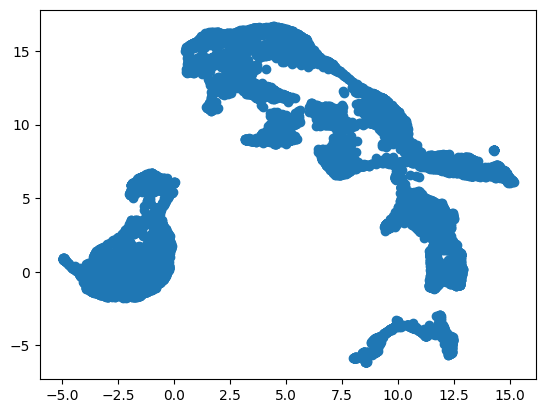

In [20]:
# embedding_rf = UMAP(
#   n_components=2,
#   n_neighbors=40,
#   min_dist=0.1,
#   metric="euclidean",
#   random_state=semillas[0],
# ).fit_transform(md)



# plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



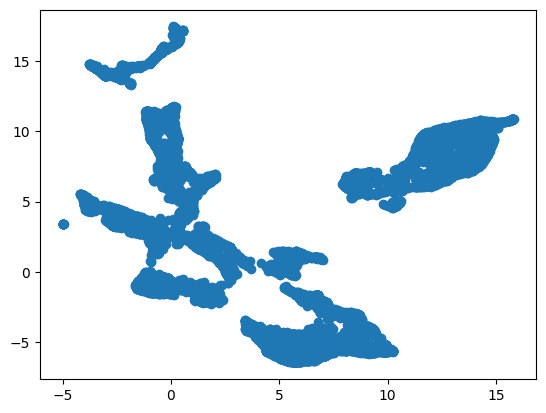

In [21]:
embedding_rf = UMAP(
    n_components=2,
    n_neighbors=40,          
    min_dist=0.05,           
    metric="euclidean",       
    spread=1.0,              
    set_op_mix_ratio=0.8,    
    random_state=semillas[0] 
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

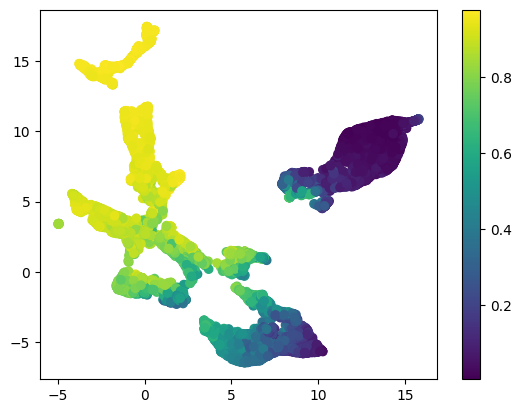

In [22]:
class_index = np.where(model_rf_1.classes_ == 1)[0]
prob_baja = model_rf_1.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

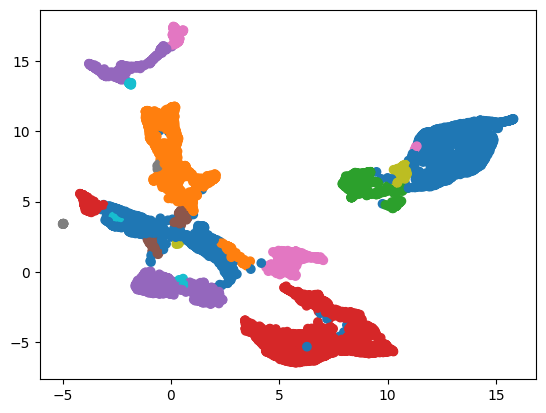

In [23]:
hdb = DBSCAN(eps=0.2)
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
# plt.tight_layout()
plt.show()

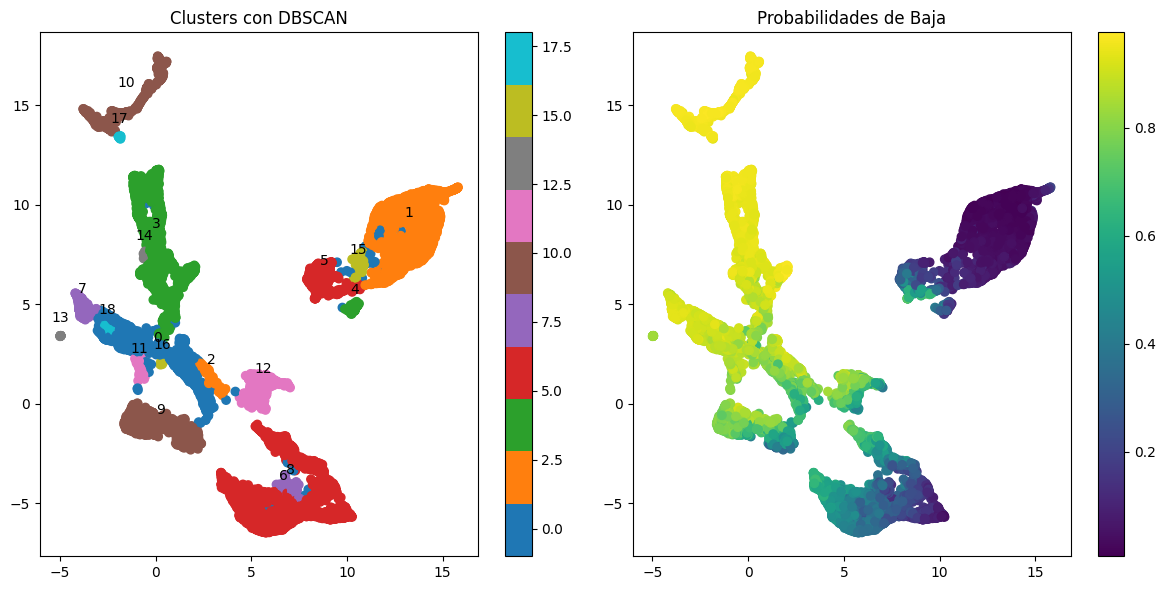

In [24]:
hdb = DBSCAN(eps=0.21)
y = hdb.fit(embedding_rf)

# Creamos la figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico: clusters con anotaciones
scatter1 = ax1.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')

# Anotamos el número de clústeres en el centro de cada grupo
unique_labels = set(y.labels_)
for label in unique_labels:
    if label == -1:  # Ignoramos el ruido (outliers)
        continue
    mask = (y.labels_ == label)
    cluster_center = embedding_rf[mask].mean(axis=0)
    ax1.annotate(f'{label}', cluster_center, textcoords="offset points", xytext=(0, 10), ha='center')

ax1.set_title('Clusters con DBSCAN')
fig.colorbar(scatter1, ax=ax1)

# Segundo gráfico: probabilidades de clase
class_index = np.where(model_rf_1.classes_ == 1)[0]
prob_baja = model_rf_1.predict_proba(Xtrain_rf_imp)[:, class_index]

scatter2 = ax2.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=prob_baja)
ax2.set_title('Probabilidades de Baja')
fig.colorbar(scatter2, ax=ax2)

# Ajustamos el layout de toda la figura
plt.tight_layout()
plt.show()

In [ ]:
pd.Series(y.labels_).value_counts()

In [ ]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  #model = RandomForestClassifier(random_state=17) yo ya tengo mi rf guardado, uso ese
  model_rf_1.fit(Xtrain_rf_imp, y_binary)

  importances = model_rf_1.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

In [ ]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:12]:
    print(f"  - {feature}")


## comparacion 1 vs 1

In [ ]:
def compare_two_clusters(df_embedding, Xtrain_rf_imp, model_rf_1, cluster_1, cluster_2, num_features=12):
    # Cluster 1
    y_binary_1 = (df_embedding['cluster'] == cluster_1).astype(int)
    importances_1 = model_rf_1.fit(Xtrain_rf_imp, y_binary_1).feature_importances_
    
    # Cluster 2
    y_binary_2 = (df_embedding['cluster'] == cluster_2).astype(int)
    importances_2 = model_rf_1.fit(Xtrain_rf_imp, y_binary_2).feature_importances_
    
    # Calculamos la diferencia entre las importancias de los clusters
    difference = importances_1 - importances_2
    feature_names = Xtrain_rf.columns
    indices = np.argsort(np.abs(difference))[::-1]
    
    important_features = [feature_names[i] for i in indices[:num_features]]
    
    print(f"Comparación entre Cluster {cluster_1} y Cluster {cluster_2}:")
    for feature in important_features:
        print(f" - {feature}")
    
    return important_features

important_features = compare_two_clusters(df_embedding, Xtrain_rf_imp, model_rf_1, 2, 6)

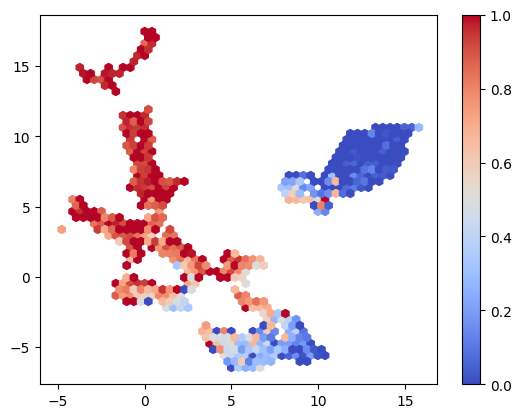

In [25]:
plt.hexbin(embedding_rf[:,0], embedding_rf[:,1], C=ytrain_rf, gridsize=50, cmap='coolwarm', reduce_C_function=np.mean)
plt.colorbar()
plt.show()

In [46]:
# Asumimos que ytrain_rf es una lista/array con 0 (no baja) y 1 (baja)
bajas = ytrain_rf == 1  # Boolean mask for bajas (1)
no_bajas = ytrain_rf == 0  # Boolean mask for no bajas (0)

# Scatter plot para los puntos "bajas"
plt.scatter(embedding_rf[bajas, 0], embedding_rf[bajas, 1], color='red', label='Baja', alpha=0.5)

# Scatter plot para los puntos "no bajas"
plt.scatter(embedding_rf[no_bajas, 0], embedding_rf[no_bajas, 1], color='blue', label='No baja', alpha=0.5)

# Agregamos etiquetas, título y leyenda
plt.title("Segmentación de Embeddings")
plt.xlabel("Embedding 1")
plt.ylabel("Embedding 2")
plt.legend()
plt.show()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 5974 but size of corresponding boolean axis is 10974

Okey al final los cluster que arme pensando y asigna una probabilidad alta de baja son una mezcla de baja y continua.. No es muy bueno el rf. Pero a miranda le interesa el perfil de las personas que se dan de baja. Podria armar cluster con solo los baja? Filtro la matriz de distancia con las etiquetas que tengo de ytrain_rf, md[ytrain_rf==1,][:,ytrain_rf==1]

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



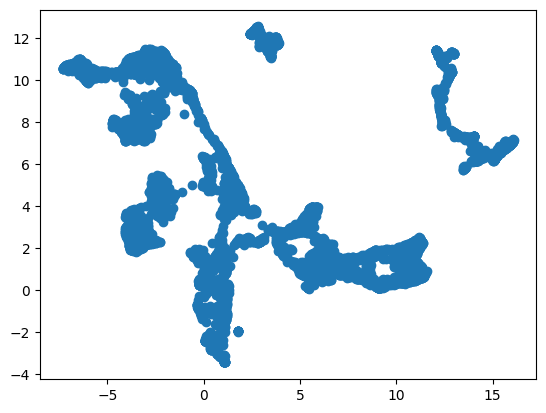

In [47]:
embedding_rf = UMAP(
    n_components=2,
    n_neighbors=40,          
    min_dist=0.05,           
    metric="euclidean",       
    spread=1.0,              
    set_op_mix_ratio=0.8,    
    random_state=semillas[0] 
).fit_transform(md[ytrain_rf==1,][:,ytrain_rf==1])

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

# embedding_rf = UMAP( 
#   n_components=2,
#   n_neighbors=50,
#   metric="precomputed",
# ).fit_transform(md[ytrain_rf==1,][:,ytrain_rf==1]) 


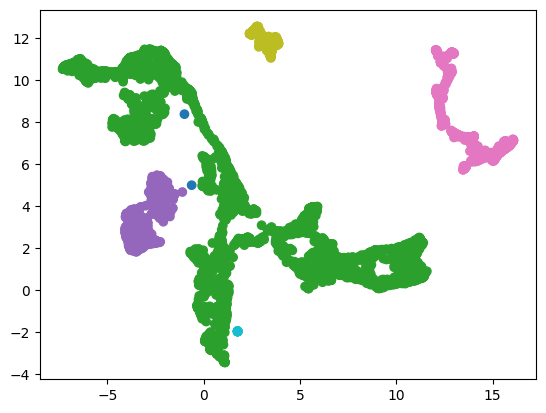

In [48]:
hdb = DBSCAN(eps=0.5)
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
# plt.tight_layout()
plt.show()

Veamos cuantos cluster detecto y cuantos clientes tiene cada uno

In [44]:
pd.Series(y.labels_).value_counts()

 0    4318
 2     743
 1     651
 3     249
 4      11
-1       2
Name: count, dtype: int64

In [52]:
indices_baja = np.where(ytrain_rf == 1)[0]  # Obtiene los índices originales de los que se dieron de baja

# Crear un dataframe para ver qué cliente pertenece a qué cluster
df_clusters = pd.DataFrame({
    'Cliente_Indice': indices_baja,
    'Cluster': y.labels_
})

# Mostrar los primeros resultados
print(df_clusters.head())

# # Ahora puedes filtrar por cada cluster
# for cluster in np.unique(y.labels_):
#     print(f"Clientes en el cluster {cluster}:")
#     print(df_clusters[df_clusters['Cluster'] == cluster])


   Cliente_Indice  Cluster
0               5        0
1               6        0
2               7        0
3               8        0
4               9        0


In [72]:
df_clusters

,Cliente_Indice,Cluster
0,5,0
1,6,0
2,7,0
3,8,0
4,9,0
...,...,...
5969,10966,0
5970,10969,0
5971,10971,1
5972,10972,1


In [87]:
## uno los datos con los que entrene el rf y arme la matriz de distancia
df_entrenamiento=pd.concat([Xtrain_rf,ytrain_rf],axis=1).reset_index() #reseteo el index para que me quede igual que la matriz de distancia

In [89]:
df_entrenamiento.shape
df_entrenamiento

,index,numero_de_cliente,lag_1_ctrx_quarter,avg_3_ctrx_quarter,ctrx_quarter,percent_rank_ctrx_quarter,mpayroll,lag_1_cpayroll_trx,mtarjeta_visa_consumo,percent_rank_mpayroll,...,avg_3_mtarjeta_visa_consumo,avg_3_cpayroll_trx,lag_1_mtarjeta_visa_consumo,percent_rank_mcuentas_saldo,mcomisiones_mantenimiento_slope_3,lag_1_mpasivos_margen,avg_3_mpayroll,Visa_msaldototal,cant_transac_tarjetas,clase_ternaria
0,203,1226922531,32.0,40.750000,19,0.067243,0.00,0.0,0.00,0.000000,...,0.0000,0.000000,0.00,0.402538,0.00,87.39,0.0000,NaN,0,0
1,217,1229432461,422.0,421.500000,471,0.993852,520580.91,2.0,291424.48,0.990008,...,189981.7600,2.000000,135788.62,0.844385,0.00,1820.29,372045.9750,-34153.28,159,0
2,245,1232984888,175.0,173.000000,171,0.792959,143046.68,2.0,90965.70,0.830476,...,70163.8550,2.000000,49362.01,0.487189,0.00,293.48,184538.2900,97649.38,23,0
3,269,1234873843,147.0,138.500000,147,0.706015,318333.43,1.0,46346.59,0.969662,...,53376.1075,1.000000,37430.69,0.548750,0.00,1471.13,270942.1775,39511.16,11,0
4,318,1243122330,6.0,6.000000,6,0.023561,0.00,0.0,557.26,0.000000,...,557.2600,0.000000,557.26,0.219021,0.00,9.96,0.0000,492.30,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10969,981406,896136165,27.0,24.750000,23,0.082381,0.00,0.0,0.00,0.000000,...,3362.9300,0.000000,0.00,0.103435,163.64,27.39,0.0000,NaN,0,1
10970,981443,696320603,92.0,95.500000,99,0.465127,76751.73,1.0,13594.01,0.632478,...,16796.4650,1.250000,13209.54,0.960776,0.00,2678.06,75583.4225,11728.17,11,0
10971,981467,1065322356,NaN,30.000000,30,0.111111,0.00,NaN,60996.00,0.000000,...,60996.0000,0.000000,NaN,0.591032,NaN,NaN,0.0000,52624.00,1,1
10972,981520,631217443,9.0,11.000000,13,0.045934,0.00,0.0,6050.33,0.000000,...,5418.0850,0.000000,4785.84,0.840820,2626.15,99.87,0.0000,5345.55,1,1


In [70]:
# baja_cluster_0 = df_clusters[df_clusters["Cluster"] == 0]["Cliente_Indice"].values
# baja_cluster_1 = df_clusters[df_clusters["Cluster"] == 1]["Cliente_Indice"].values
# baja_cluster_2 = df_clusters[df_clusters["Cluster"] == 2]["Cliente_Indice"].values
# baja_cluster_3 = df_clusters[df_clusters["Cluster"] == 3]["Cliente_Indice"].values
# baja_cluster_4 = df_clusters[df_clusters["Cluster"] == 4]["Cliente_Indice"].values

# # Filtrar el dataframe original usando esos índices
# df_cluster_0 = df_entrenamiento.iloc[baja_cluster_0]
# df_cluster_1 = df_entrenamiento.iloc[baja_cluster_1]
# df_cluster_2 = df_entrenamiento.iloc[baja_cluster_2]
# df_cluster_3 = df_entrenamiento.iloc[baja_cluster_3]
# df_cluster_4 = df_entrenamiento.iloc[baja_cluster_4]

## muy tedioso mejor tener un solo df y una columna que identifique a cada cluster baja

In [85]:
df_entrenamiento.head(5)

,index,numero_de_cliente,lag_1_ctrx_quarter,avg_3_ctrx_quarter,ctrx_quarter,percent_rank_ctrx_quarter,mpayroll,lag_1_cpayroll_trx,mtarjeta_visa_consumo,percent_rank_mpayroll,...,avg_3_mtarjeta_visa_consumo,avg_3_cpayroll_trx,lag_1_mtarjeta_visa_consumo,percent_rank_mcuentas_saldo,mcomisiones_mantenimiento_slope_3,lag_1_mpasivos_margen,avg_3_mpayroll,Visa_msaldototal,cant_transac_tarjetas,clase_ternaria
0,203,1226922531,32.0,40.75,19,0.067243,0.00,0.0,0.00,0.000000,...,0.0000,0.0,0.00,0.402538,0.0,87.39,0.0000,NaN,0,0
1,217,1229432461,422.0,421.50,471,0.993852,520580.91,2.0,291424.48,0.990008,...,189981.7600,2.0,135788.62,0.844385,0.0,1820.29,372045.9750,-34153.28,159,0
2,245,1232984888,175.0,173.00,171,0.792959,143046.68,2.0,90965.70,0.830476,...,70163.8550,2.0,49362.01,0.487189,0.0,293.48,184538.2900,97649.38,23,0
3,269,1234873843,147.0,138.50,147,0.706015,318333.43,1.0,46346.59,0.969662,...,53376.1075,1.0,37430.69,0.548750,0.0,1471.13,270942.1775,39511.16,11,0
4,318,1243122330,6.0,6.00,6,0.023561,0.00,0.0,557.26,0.000000,...,557.2600,0.0,557.26,0.219021,0.0,9.96,0.0000,492.30,1,0


In [95]:
df_entrenamiento_copy = df_entrenamiento.copy()

# Asignar los clusters a los clientes de acuerdo a 'Cliente_Indice' como índice
df_entrenamiento_copy.loc[df_clusters["Cliente_Indice"], "Cluster"] = df_clusters["Cluster"].values

df_bajas=df_entrenamiento_copy.loc[df_entrenamiento_copy["clase_ternaria"]==1]

In [96]:
df_bajas.drop("index",axis=1,inplace=True)

C:\Users\Federico\AppData\Local\Temp\ipykernel_4720\2910127775.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
df_bajas.groupby("Cluster")["mpayroll"].mean()

Cluster
-1.0         0.000000
 0.0        74.598726
 1.0        51.122596
 2.0         0.000000
 3.0    168885.416867
 4.0         0.000000
Name: mpayroll, dtype: float64

Los que tienen -1, son considerados outliers.

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

Y exploramos cuales son las variables importantes por cada cluster

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda
